In [1]:
import pandas as pd 
import numpy as np
import time 

# Add directory above current directory to path
import sys; 
if not ".." in sys.path:
    sys.path.insert(0, '..')

import matplotlib.pyplot as plt                  # plots

import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions

%load_ext autoreload
%autoreload 2

%matplotlib inline

First we import the login data.

In [2]:
#passing a list of datatypes for the columns
login_dtypes = {"ID": int, "RES_ID": int, "DATE_SAVED": str, "DATE_LAST_MODIFIED": str, "CUST_CODE": str, 
            "IS_ARRIVED": str, "LOCATION": int, "COMPUTED_RSV_ID": str}

#columns that are given as dates can be parsed while reading 
login_date_columns = ['DATE_SAVED', 'DATE_LAST_MODIFIED']

login_data_sanitized = pd.read_csv("../DATA_GYM/sanitized_login_data.csv", dtype=login_dtypes, parse_dates=login_date_columns)

The reservation card imported above is a description of the customer base of all the gyms. Some of the most important columns are:

CUST_CODE (string, format: int1DOTint2): Unique customer identifier. Perhaps translate to int for an easier handling?

EXPIRE_DATE (datetime object, format YYYY-MM-DD): Date of contract expiry.

MEMBER_SINCE (datetime object, format YYYY-MM-DD): Date of contract signing. Sometimes day, sometimes second accuracy -> maybe truncate entries to day format.

--> The membership duration for a given customer cust_id is then just reservation_card[cust_id][EXPIRE_DATE] - reservation_card[cust_id][MEMBER_SINCE].

IS_ACTIVE (bool, encoded as F or T): Whether the contract is still active. For these, the expiry date is set to December 31st, 2100.

SEX (string): Gender of customer. Either "M" (male) or "F" (female).

In [3]:
#Sets the ID as the index of login_data_sanitized. 
#Running twice will result in a KeyError exception
login_data_sanitized = login_data_sanitized.set_index("ID")

login_sample = login_data_sanitized.iloc[0]

login_sample

RES_ID                              50521
DATE_SAVED            2013-04-16 10:47:58
DATE_LAST_MODIFIED    2013-04-16 10:47:58
CUST_CODE                         2079.10
IS_ARRIVED                              T
LOCATION                               10
COMPUTED_RSV_ID                   1051742
DATE                           2013-04-16
MONTH                                   4
WEEK                                   16
DAYOFWEEK                               1
Name: 51742, dtype: object

In [4]:
login_data_sanitized

,RES_ID,DATE_SAVED,DATE_LAST_MODIFIED,CUST_CODE,IS_ARRIVED,LOCATION,COMPUTED_RSV_ID,DATE,MONTH,WEEK,DAYOFWEEK
ID,,,,,,,,,,,
51742,50521,2013-04-16 10:47:58,2013-04-16 10:47:58,2079.10,T,10,1051742,2013-04-16,4,16,1
51743,50541,2013-04-16 11:39:41,2013-04-16 11:39:41,4032.10,T,10,1051743,2013-04-16,4,16,1
52517,49331,2013-04-16 14:25:41,2013-04-16 14:25:41,8002122.80,T,80,8052517,2013-04-16,4,16,1
52521,51993,2013-04-16 14:28:50,2013-04-16 14:28:50,4001177.50,T,50,5052521,2013-04-16,4,16,1
52523,49331,2013-04-16 14:32:15,2013-04-16 14:32:15,8000958.80,T,80,8052523,2013-04-16,4,16,1
...,...,...,...,...,...,...,...,...,...,...,...
9937009,9562848,2018-09-13 09:48:16,2018-09-13 09:48:16,1013112.44,T,44,449937009,2018-09-13,9,37,3
9937011,9531165,2018-09-13 09:49:13,2018-09-13 09:49:13,2902378.42,T,42,429937011,2018-09-13,9,37,3
9937012,8263662,2018-09-13 09:49:57,2018-09-13 09:49:57,2150687.29,T,240,2409937012,2018-09-13,9,37,3


In [5]:
#passing a list of datatypes for the columns of customer base
customer_dtypes = {'ISACTIVE': bool, "CUST_CODE": str, 'CLASS_CODE': str, 'BUSINESS_CODE': str, 'SEX': str, 'NO_MAIL': str, 
                   'NO_SMS': str, 'COMPANY_CUST_CODE': str, 'IS_DROP_IN_CUSTOMER': str}

#list of columns that will be parsed as dates
customer_date_cols = ['EXPIRE_DATE', 'LAST_VISIT', 'DATE_SAVED', 'DATE_LAST_MODIFIED', 'RENEW_DATE', 'PAUSE_START', 'PAUSE_END', 'MEMBER_SINCE']

#first row in RES_CARD.xlsx is a nonsense entry, so skip it. HEADER COUNTS --> FIRST ROW HAS INDEX 1
rows_to_skip = [1]

customer_base = pd.read_csv('../DATA_GYM/sanitized_customer_base.csv', skiprows=rows_to_skip, dtype=customer_dtypes, parse_dates=customer_date_cols, index_col=0)

In [6]:
customer_base

,ISACTIVE,EXPIRE_DATE,LAST_VISIT,CLASS_CODE,DATE_SAVED,DATE_LAST_MODIFIED,RENEW_DATE,PAUSE_START,PAUSE_END,BUSINESS_CODE,SEX,NO_MAIL,NO_SMS,MEMBER_SINCE,COMPANY_CUST_CODE,IS_DROP_IN_CUSTOMER,CONTRACT_DURATION,ACTIVE_DURATION,NUM_VISITS
CUST_CODE,,,,,,,,,,,,,,,,,,,
4766.10,False,2013-05-19,2013-04-16,10.10,2013-04-16 10:03:17,2014-06-11 12:02:14,1899-12-30,1899-12-30,1899-12-30,10.10,F,False,False,2012-11-20 00:00:00,NaN,False,180 days 00:00:00.000000000,147 days 00:00:00.000000000,1
4674.10,False,2013-09-30,2013-04-16,10.10,2013-04-16 10:03:19,2014-06-11 12:02:15,1899-12-30,1899-12-30,1899-12-30,10.10,F,False,False,2012-11-01 00:00:00,NaN,False,333 days 00:00:00.000000000,166 days 00:00:00.000000000,1
9000130.90,False,2013-07-25,2013-04-16,10.90,2013-04-16 11:24:11,2013-09-26 16:18:43,1899-12-30,1899-12-30,1899-12-30,10.90,NaN,False,False,2012-09-18 00:00:00,NaN,False,310 days 00:00:00.000000000,210 days 00:00:00.000000000,1
2002108.30,False,2013-04-21,2013-04-16,10.30,2013-04-16 11:55:51,2014-09-22 15:02:53,1899-12-30,1899-12-30,1899-12-30,10.30,F,False,False,2012-11-21 00:00:00,NaN,False,151 days 00:00:00.000000000,146 days 00:00:00.000000000,1
2001597.30,False,2013-12-04,2013-04-16,10.30,2013-04-16 11:56:02,2015-10-08 11:06:09,1899-12-30,1899-12-30,1899-12-30,10.30,F,False,False,2012-06-04 00:00:00,NaN,False,548 days 00:00:00.000000000,316 days 00:00:00.000000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007862.40,True,2100-12-31,NaT,10.40,2018-08-09 15:39:32,2018-09-10 09:25:45,NaT,NaT,NaT,10.40,F,False,False,2018-08-09 00:00:00,NaN,False,35 days 07:57:31.000000000,0 days 00:00:00.000000000,1
9005399.90,True,2018-10-08,NaT,10.90,2018-08-09 16:50:40,2018-09-10 09:25:33,NaT,NaT,NaT,10.90,M,False,False,2018-08-09 00:00:00,NaN,False,35 days 07:57:31.000000000,0 days 00:00:00.000000000,1
2355391.33,True,2100-12-31,NaT,10.33,2018-08-10 11:17:16,2018-09-10 09:25:55,NaT,NaT,NaT,10.33,F,False,False,2018-08-10 00:00:00,NaN,False,34 days 07:57:31.000000000,0 days 00:00:00.000000000,1


In [7]:
customer_features = customer_base.copy(deep=True)

In [8]:
#get the total visits of all customers
total_visits = login_data_sanitized.CUST_CODE.value_counts()
customer_features["NUM_VISITS"] = total_visits
customer_features["NUM_VISITS"].fillna(0, inplace=True)

In [9]:
customer_features

,ISACTIVE,EXPIRE_DATE,LAST_VISIT,CLASS_CODE,DATE_SAVED,DATE_LAST_MODIFIED,RENEW_DATE,PAUSE_START,PAUSE_END,BUSINESS_CODE,SEX,NO_MAIL,NO_SMS,MEMBER_SINCE,COMPANY_CUST_CODE,IS_DROP_IN_CUSTOMER,CONTRACT_DURATION,ACTIVE_DURATION,NUM_VISITS
CUST_CODE,,,,,,,,,,,,,,,,,,,
4766.10,False,2013-05-19,2013-04-16,10.10,2013-04-16 10:03:17,2014-06-11 12:02:14,1899-12-30,1899-12-30,1899-12-30,10.10,F,False,False,2012-11-20 00:00:00,NaN,False,180 days 00:00:00.000000000,147 days 00:00:00.000000000,1
4674.10,False,2013-09-30,2013-04-16,10.10,2013-04-16 10:03:19,2014-06-11 12:02:15,1899-12-30,1899-12-30,1899-12-30,10.10,F,False,False,2012-11-01 00:00:00,NaN,False,333 days 00:00:00.000000000,166 days 00:00:00.000000000,1
9000130.90,False,2013-07-25,2013-04-16,10.90,2013-04-16 11:24:11,2013-09-26 16:18:43,1899-12-30,1899-12-30,1899-12-30,10.90,NaN,False,False,2012-09-18 00:00:00,NaN,False,310 days 00:00:00.000000000,210 days 00:00:00.000000000,1
2002108.30,False,2013-04-21,2013-04-16,10.30,2013-04-16 11:55:51,2014-09-22 15:02:53,1899-12-30,1899-12-30,1899-12-30,10.30,F,False,False,2012-11-21 00:00:00,NaN,False,151 days 00:00:00.000000000,146 days 00:00:00.000000000,1
2001597.30,False,2013-12-04,2013-04-16,10.30,2013-04-16 11:56:02,2015-10-08 11:06:09,1899-12-30,1899-12-30,1899-12-30,10.30,F,False,False,2012-06-04 00:00:00,NaN,False,548 days 00:00:00.000000000,316 days 00:00:00.000000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007862.40,True,2100-12-31,NaT,10.40,2018-08-09 15:39:32,2018-09-10 09:25:45,NaT,NaT,NaT,10.40,F,False,False,2018-08-09 00:00:00,NaN,False,35 days 07:57:31.000000000,0 days 00:00:00.000000000,1
9005399.90,True,2018-10-08,NaT,10.90,2018-08-09 16:50:40,2018-09-10 09:25:33,NaT,NaT,NaT,10.90,M,False,False,2018-08-09 00:00:00,NaN,False,35 days 07:57:31.000000000,0 days 00:00:00.000000000,1
2355391.33,True,2100-12-31,NaT,10.33,2018-08-10 11:17:16,2018-09-10 09:25:55,NaT,NaT,NaT,10.33,F,False,False,2018-08-10 00:00:00,NaN,False,34 days 07:57:31.000000000,0 days 00:00:00.000000000,1


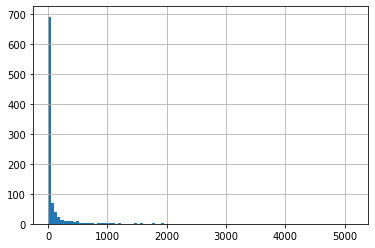

In [11]:
visits = customer_features["NUM_VISITS"].value_counts()
visits.hist(bins=100)


In [12]:
customer_features["CONTRACT_DURATION"] = customer_features.apply(lambda x: x.CONTRACT_DURATION / pd.Timedelta(days=1), axis=1) 


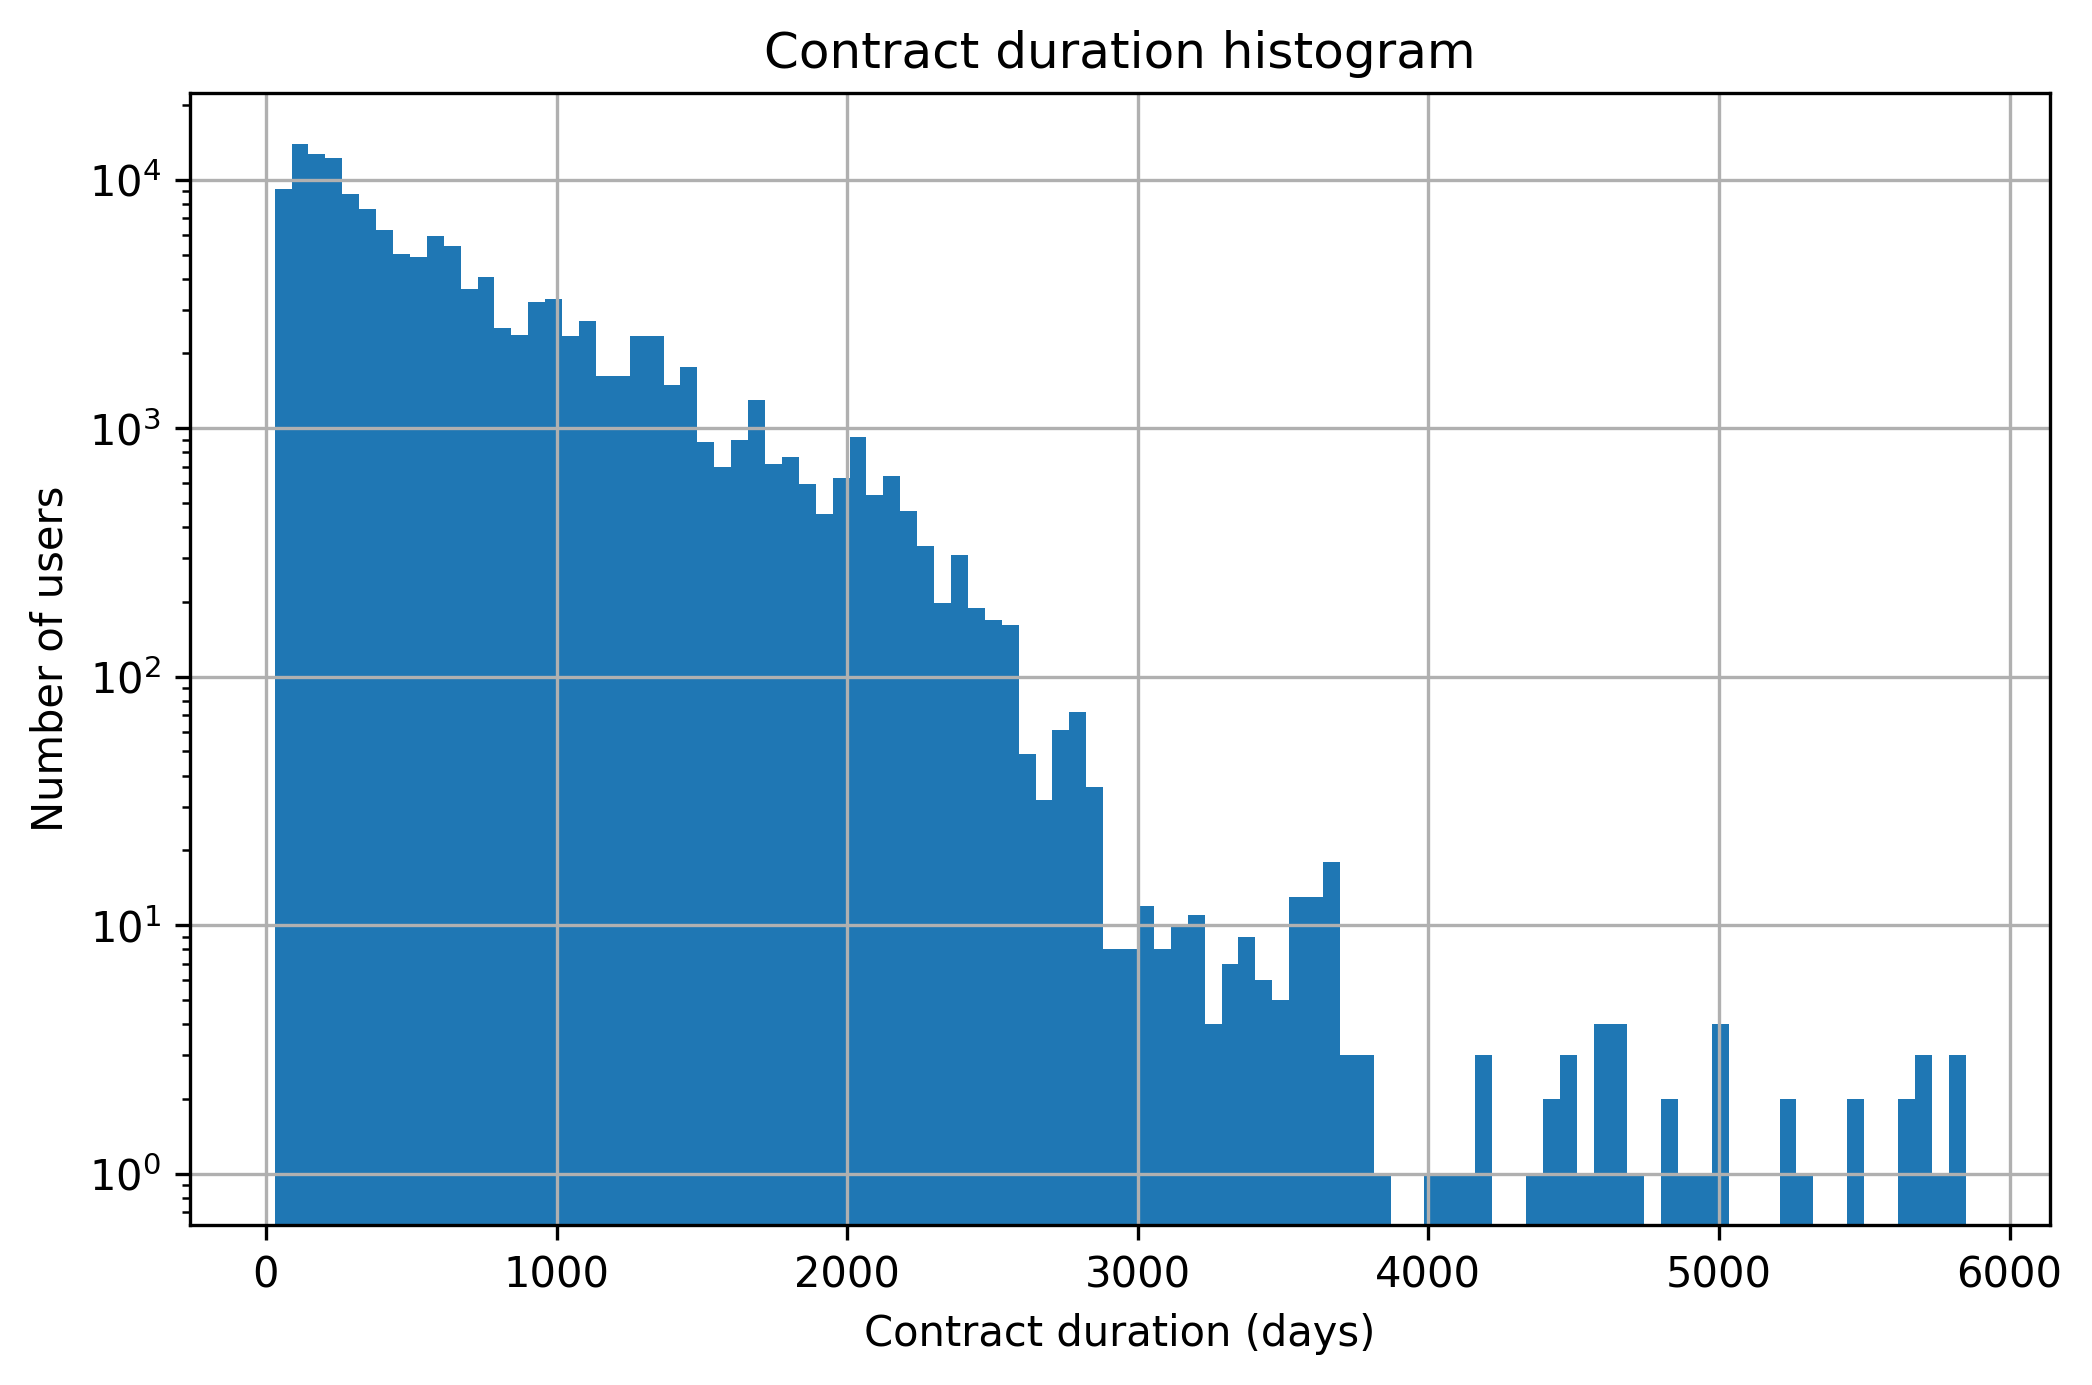

In [13]:
fig, ax = plt.subplots(figsize=(8,5), dpi=300)
ax.set_xlabel("Contract duration (days)")
ax.set_ylabel("Number of users")
ax.set_title("Contract duration histogram")
ax.set_yscale("log")
customer_features["CONTRACT_DURATION"].hist(bins=100)


In [53]:
p = np.polyfit(visits.index, np.log(visits.values), 1)
p
#scs.geom.fit(visits)
#bep = np.arange(0,1000)
#fits = 

array([-0.00577547,  5.50538886])

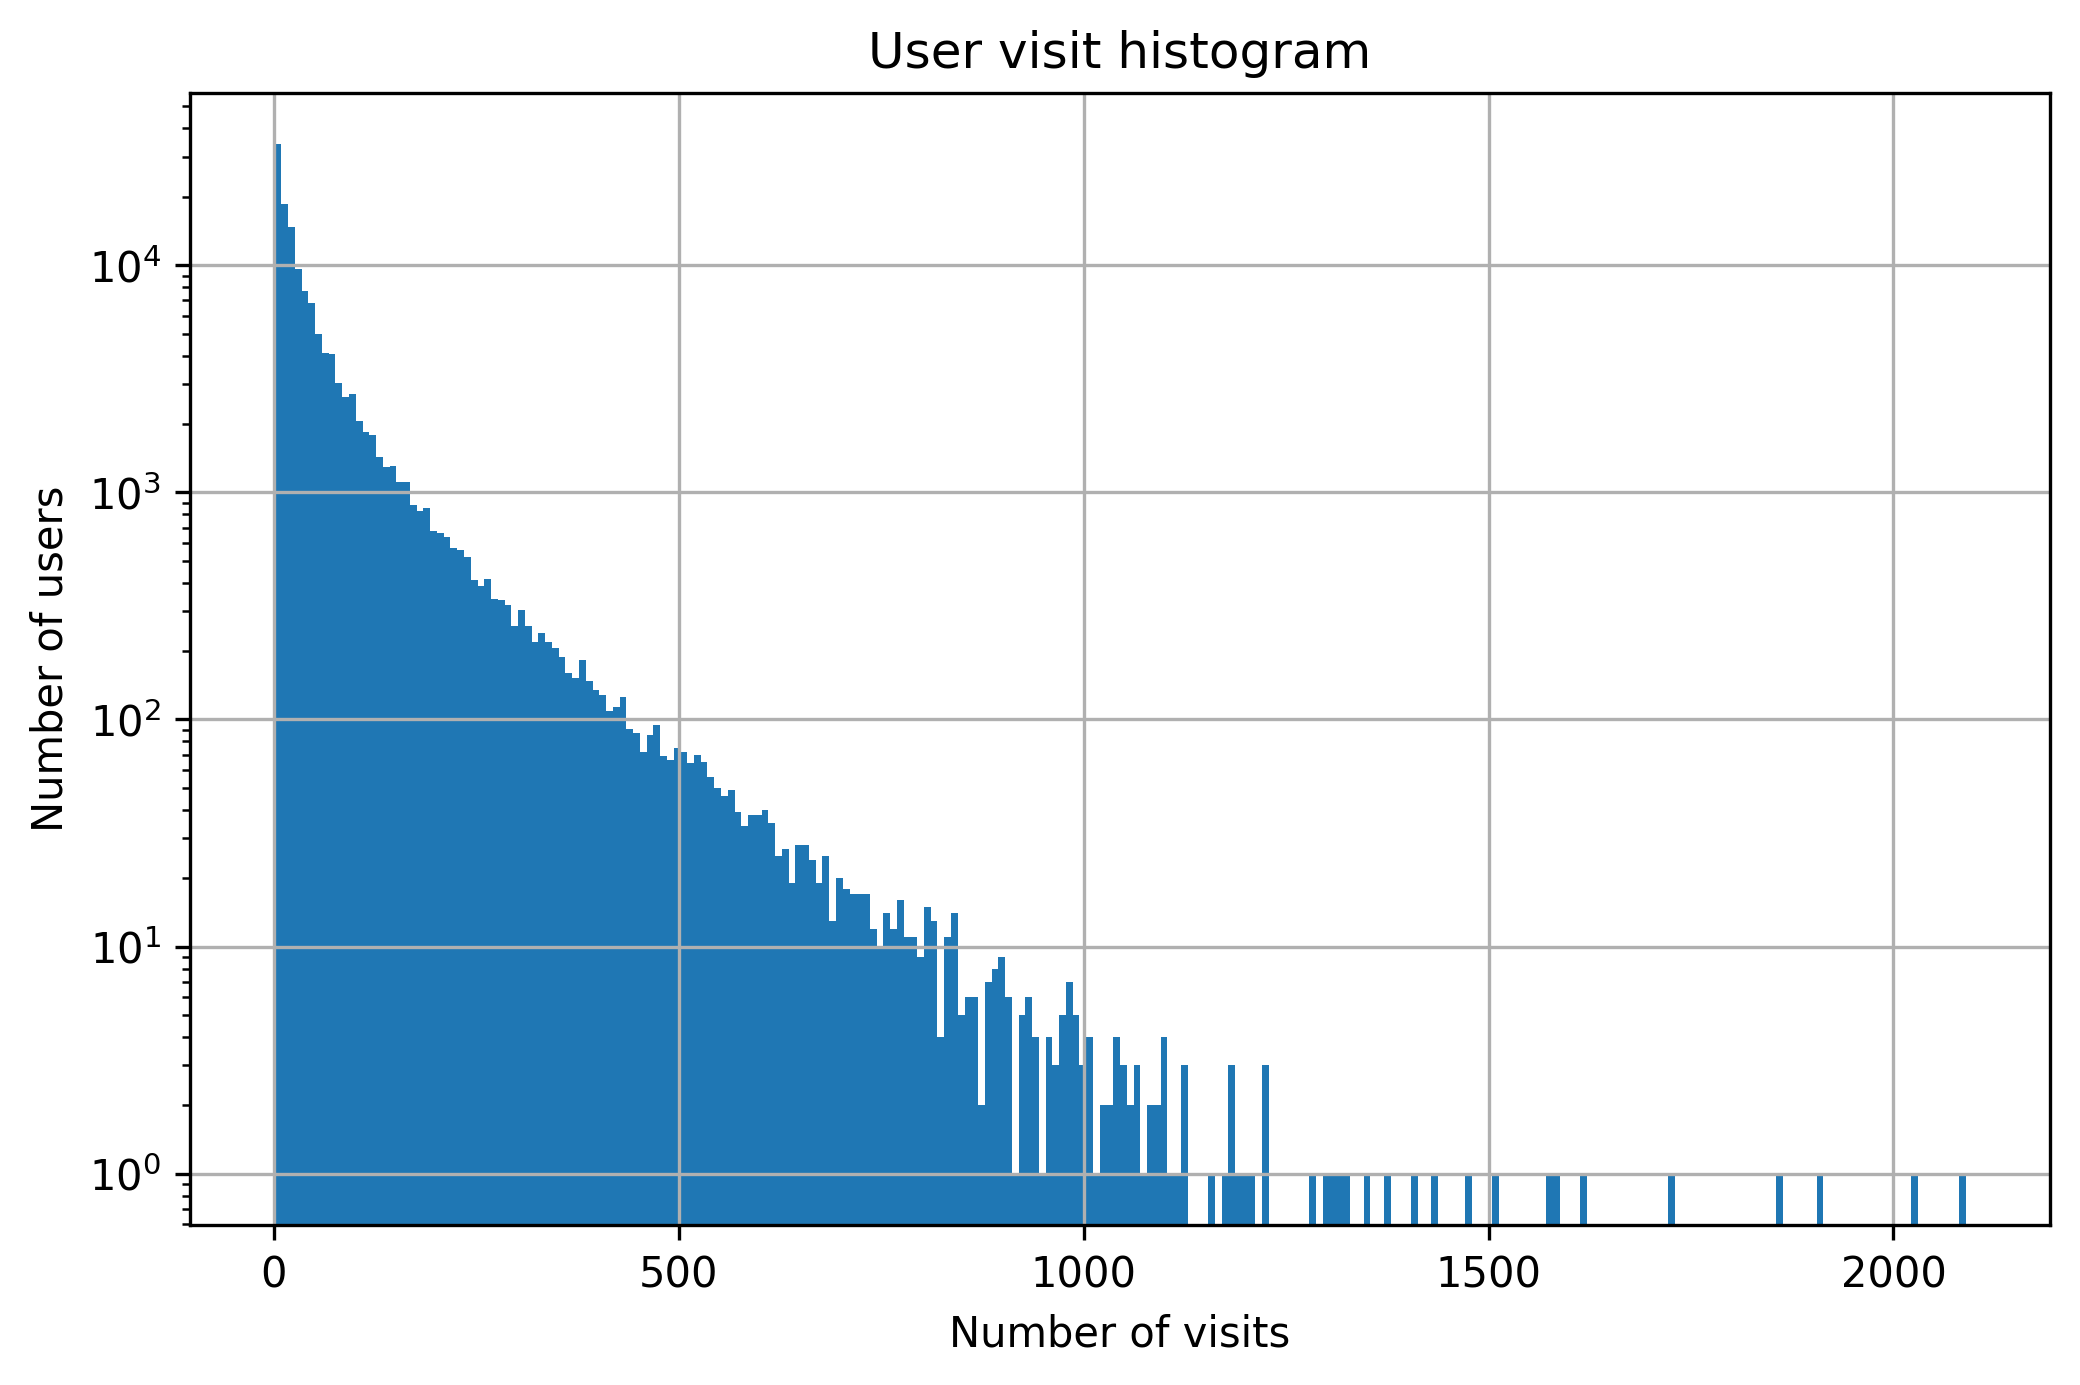

In [14]:
fig, ax = plt.subplots(figsize=(8,5), dpi=300)
#c = customer_features[customer_features.NUM_VISITS < 100]
customer_features["NUM_VISITS"].hist(bins=250, ax=ax)
ax.set_xlabel("Number of visits")
ax.set_ylabel("Number of users")
ax.set_title("User visit histogram")
#ax.set_xlim(0,400)
ax.set_yscale("log")

In [15]:
fig.savefig("../plots/result_plots/num_logins_hist.pdf", format='pdf', bbox_inches='tight')

In [11]:
#get the customer contract durations
last_log_date = pd.to_datetime(login_data_sanitized.DATE_SAVED.max())

customer_features["CONTRACT_DUR_DAYS"] = customer_base.apply(lambda x: (x.EXPIRE_DATE - x.MEMBER_SINCE) / pd.Timedelta(days=1) if not x.ISACTIVE else (last_log_date - x.MEMBER_SINCE) / pd.Timedelta(days=1) , axis=1)

In [12]:
from feature_extraction import get_time_of_day_visits, get_seasonal_visits, get_quarterly_visits

In [16]:
#drop logins with unknown customer codes
unknown_customer_logins = login_data_sanitized[~login_data_sanitized.CUST_CODE.isin(customer_features.index)]

login_data_sanitized.drop(unknown_customer_logins.index, inplace=True)

login_copy = login_data_sanitized.copy()

login_copy

,RES_ID,DATE_SAVED,DATE_LAST_MODIFIED,CUST_CODE,IS_ARRIVED,LOCATION,COMPUTED_RSV_ID,DATE,MONTH,WEEK,DAYOFWEEK
ID,,,,,,,,,,,
51742,50521,2013-04-16 10:47:58,2013-04-16 10:47:58,2079.10,T,10,1051742,2013-04-16,4,16,1
51743,50541,2013-04-16 11:39:41,2013-04-16 11:39:41,4032.10,T,10,1051743,2013-04-16,4,16,1
52517,49331,2013-04-16 14:25:41,2013-04-16 14:25:41,8002122.80,T,80,8052517,2013-04-16,4,16,1
52521,51993,2013-04-16 14:28:50,2013-04-16 14:28:50,4001177.50,T,50,5052521,2013-04-16,4,16,1
52523,49331,2013-04-16 14:32:15,2013-04-16 14:32:15,8000958.80,T,80,8052523,2013-04-16,4,16,1
...,...,...,...,...,...,...,...,...,...,...,...
9937009,9562848,2018-09-13 09:48:16,2018-09-13 09:48:16,1013112.44,T,44,449937009,2018-09-13,9,37,3
9937011,9531165,2018-09-13 09:49:13,2018-09-13 09:49:13,2902378.42,T,42,429937011,2018-09-13,9,37,3
9937012,8263662,2018-09-13 09:49:57,2018-09-13 09:49:57,2150687.29,T,240,2409937012,2018-09-13,9,37,3


In [17]:
login_copy.sort_values(by=["CUST_CODE", "DATE_SAVED"], inplace=True)

login_copy

,RES_ID,DATE_SAVED,DATE_LAST_MODIFIED,CUST_CODE,IS_ARRIVED,LOCATION,COMPUTED_RSV_ID,DATE,MONTH,WEEK,DAYOFWEEK
ID,,,,,,,,,,,
3236333,3235928,2015-09-17 14:15:12,2015-09-17 14:15:12,10000.10,T,10,10 3236333,2015-09-17,9,38,3
3245603,3245382,2015-09-18 09:36:00,2015-09-18 09:36:00,10000.10,T,10,10 3245603,2015-09-18,9,38,4
3259998,3259184,2015-09-22 18:44:40,2015-09-22 18:44:40,10000.10,T,10,10 3259998,2015-09-22,9,39,1
3270124,3269660,2015-09-24 15:06:05,2015-09-24 15:06:05,10000.10,T,10,10 3270124,2015-09-24,9,39,3
3278900,3278716,2015-09-25 09:06:35,2015-09-25 09:06:35,10000.10,T,10,10 3278900,2015-09-25,9,39,4
...,...,...,...,...,...,...,...,...,...,...,...
9898728,9863415,2018-09-06 18:15:04,2018-09-06 18:15:04,99999999,T,34,349898728,2018-09-06,9,36,3
9898730,9863397,2018-09-06 18:15:07,2018-09-06 18:15:07,99999999,T,34,349898730,2018-09-06,9,36,3
9898823,9863397,2018-09-06 18:23:27,2018-09-06 18:23:27,99999999,T,34,349898823,2018-09-06,9,36,3


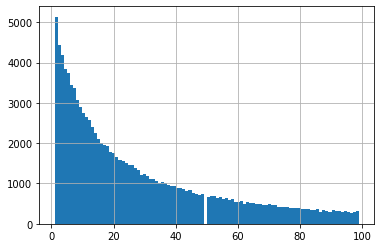

In [18]:
visit_nums = login_copy.CUST_CODE.value_counts()

visit_nums[visit_nums < 100].hist(bins=100)

In [ ]:
get_time_of_day_visits(customer_features, login_copy, verbose=True)

In [17]:
customer_features

,ISACTIVE,EXPIRE_DATE,LAST_VISIT,CLASS_CODE,DATE_SAVED,DATE_LAST_MODIFIED,RENEW_DATE,PAUSE_START,PAUSE_END,BUSINESS_CODE,...,NO_SMS,MEMBER_SINCE,COMPANY_CUST_CODE,IS_DROP_IN_CUSTOMER,NUM_VISITS,CONTRACT_DUR_DAYS,night_visits,morning_visits,afternoon_visits,evening_visits
CUST_CODE,,,,,,,,,,,,,,,,,,,,,
4766.10,False,2013-05-19,2013-04-16,10.10,2013-04-16 10:03:17,2014-06-11 12:02:14,1899-12-30,1899-12-30,1899-12-30,10.10,...,False,2012-11-20 00:00:00,NaN,False,1.0,2123.410463,0.0,0.0,0.0,1.0
4674.10,False,2013-09-30,2013-04-16,10.10,2013-04-16 10:03:19,2014-06-11 12:02:15,1899-12-30,1899-12-30,1899-12-30,10.10,...,False,2012-11-01 00:00:00,NaN,False,1.0,2142.410463,0.0,0.0,0.0,1.0
9000130.90,False,2013-07-25,2013-04-16,10.90,2013-04-16 11:24:11,2013-09-26 16:18:43,1899-12-30,1899-12-30,1899-12-30,10.90,...,False,2012-09-18 00:00:00,NaN,False,1.0,2186.410463,0.0,0.0,0.0,1.0
2002108.30,False,2013-04-21,2013-04-16,10.30,2013-04-16 11:55:51,2014-09-22 15:02:53,1899-12-30,1899-12-30,1899-12-30,10.30,...,False,2012-11-21 00:00:00,NaN,False,1.0,2122.410463,0.0,0.0,1.0,0.0
2001597.30,False,2013-12-04,2013-04-16,10.30,2013-04-16 11:56:02,2015-10-08 11:06:09,1899-12-30,1899-12-30,1899-12-30,10.30,...,False,2012-06-04 00:00:00,NaN,False,1.0,2292.410463,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453127.35,True,2100-12-31,NaT,10,2018-09-12 22:17:52,2018-09-12 22:17:55,NaT,NaT,NaT,NaN,...,False,2018-09-12 22:17:52,NaN,False,0.0,0.481389,0.0,0.0,0.0,0.0
2154501.29,True,2100-12-31,NaT,10,2018-09-12 22:42:12,2018-09-12 22:42:16,NaT,NaT,NaT,NaN,...,False,2018-09-12 22:42:12,NaN,False,0.0,0.464491,0.0,0.0,0.0,0.0
2154502.29,True,2100-12-31,NaT,10,2018-09-12 22:54:27,2018-09-12 22:54:31,NaT,NaT,NaT,NaN,...,False,2018-09-12 22:54:27,NaN,False,0.0,0.455984,0.0,0.0,0.0,0.0


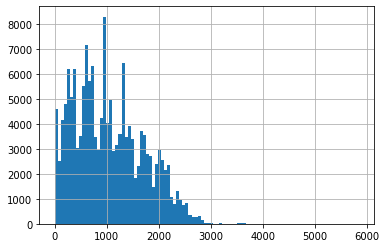

In [18]:
customer_features["CONTRACT_DUR_DAYS"].hist(bins=100)

In [ ]:
get_quarterly_visits(customer_features, login_copy, verbose=True)

In [ ]:
get_seasonal_visits(customer_features, login_copy, verbose=True)

In [ ]:
get_binary_visit_apen(customer_features, login_copy, verbose=True)

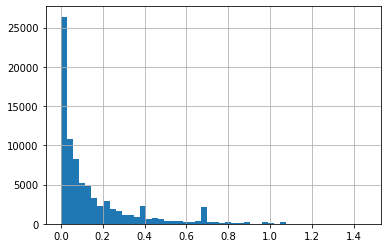

In [267]:
customer_features["binary_visit_apen_m=2"].hist(bins=50)

customer_features

In [ ]:
get_binary_visit_apen(customer_features, login_copy, m=3, verbose=True)

# Fitting a Hidden Markov Model to uncover usage patterns

Now, we try to fit a HMM to uncover some usage patterns based on the times between visits. To do this, we get the timedeltas and write them to a file. 

In [20]:
from utils.time_utils import write_timedeltas_to_file, get_timedelta_sample

In [ ]:
write_timedeltas_to_file(login_copy, "larger_sample.csv", num_users=16450, is_sorted=True,verbose=True, compression="gzip")

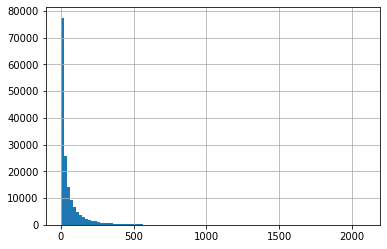

In [28]:
customer_features.NUM_VISITS.hist(bins=100)

In [ ]:
write_timedeltas_to_file(login_copy, "timedeltas.csv", is_sorted=True, verbose=True, compression="gzip")

In [ ]:
td_sample = get_timedelta_sample(login_copy, verbose=True, is_sorted=True)

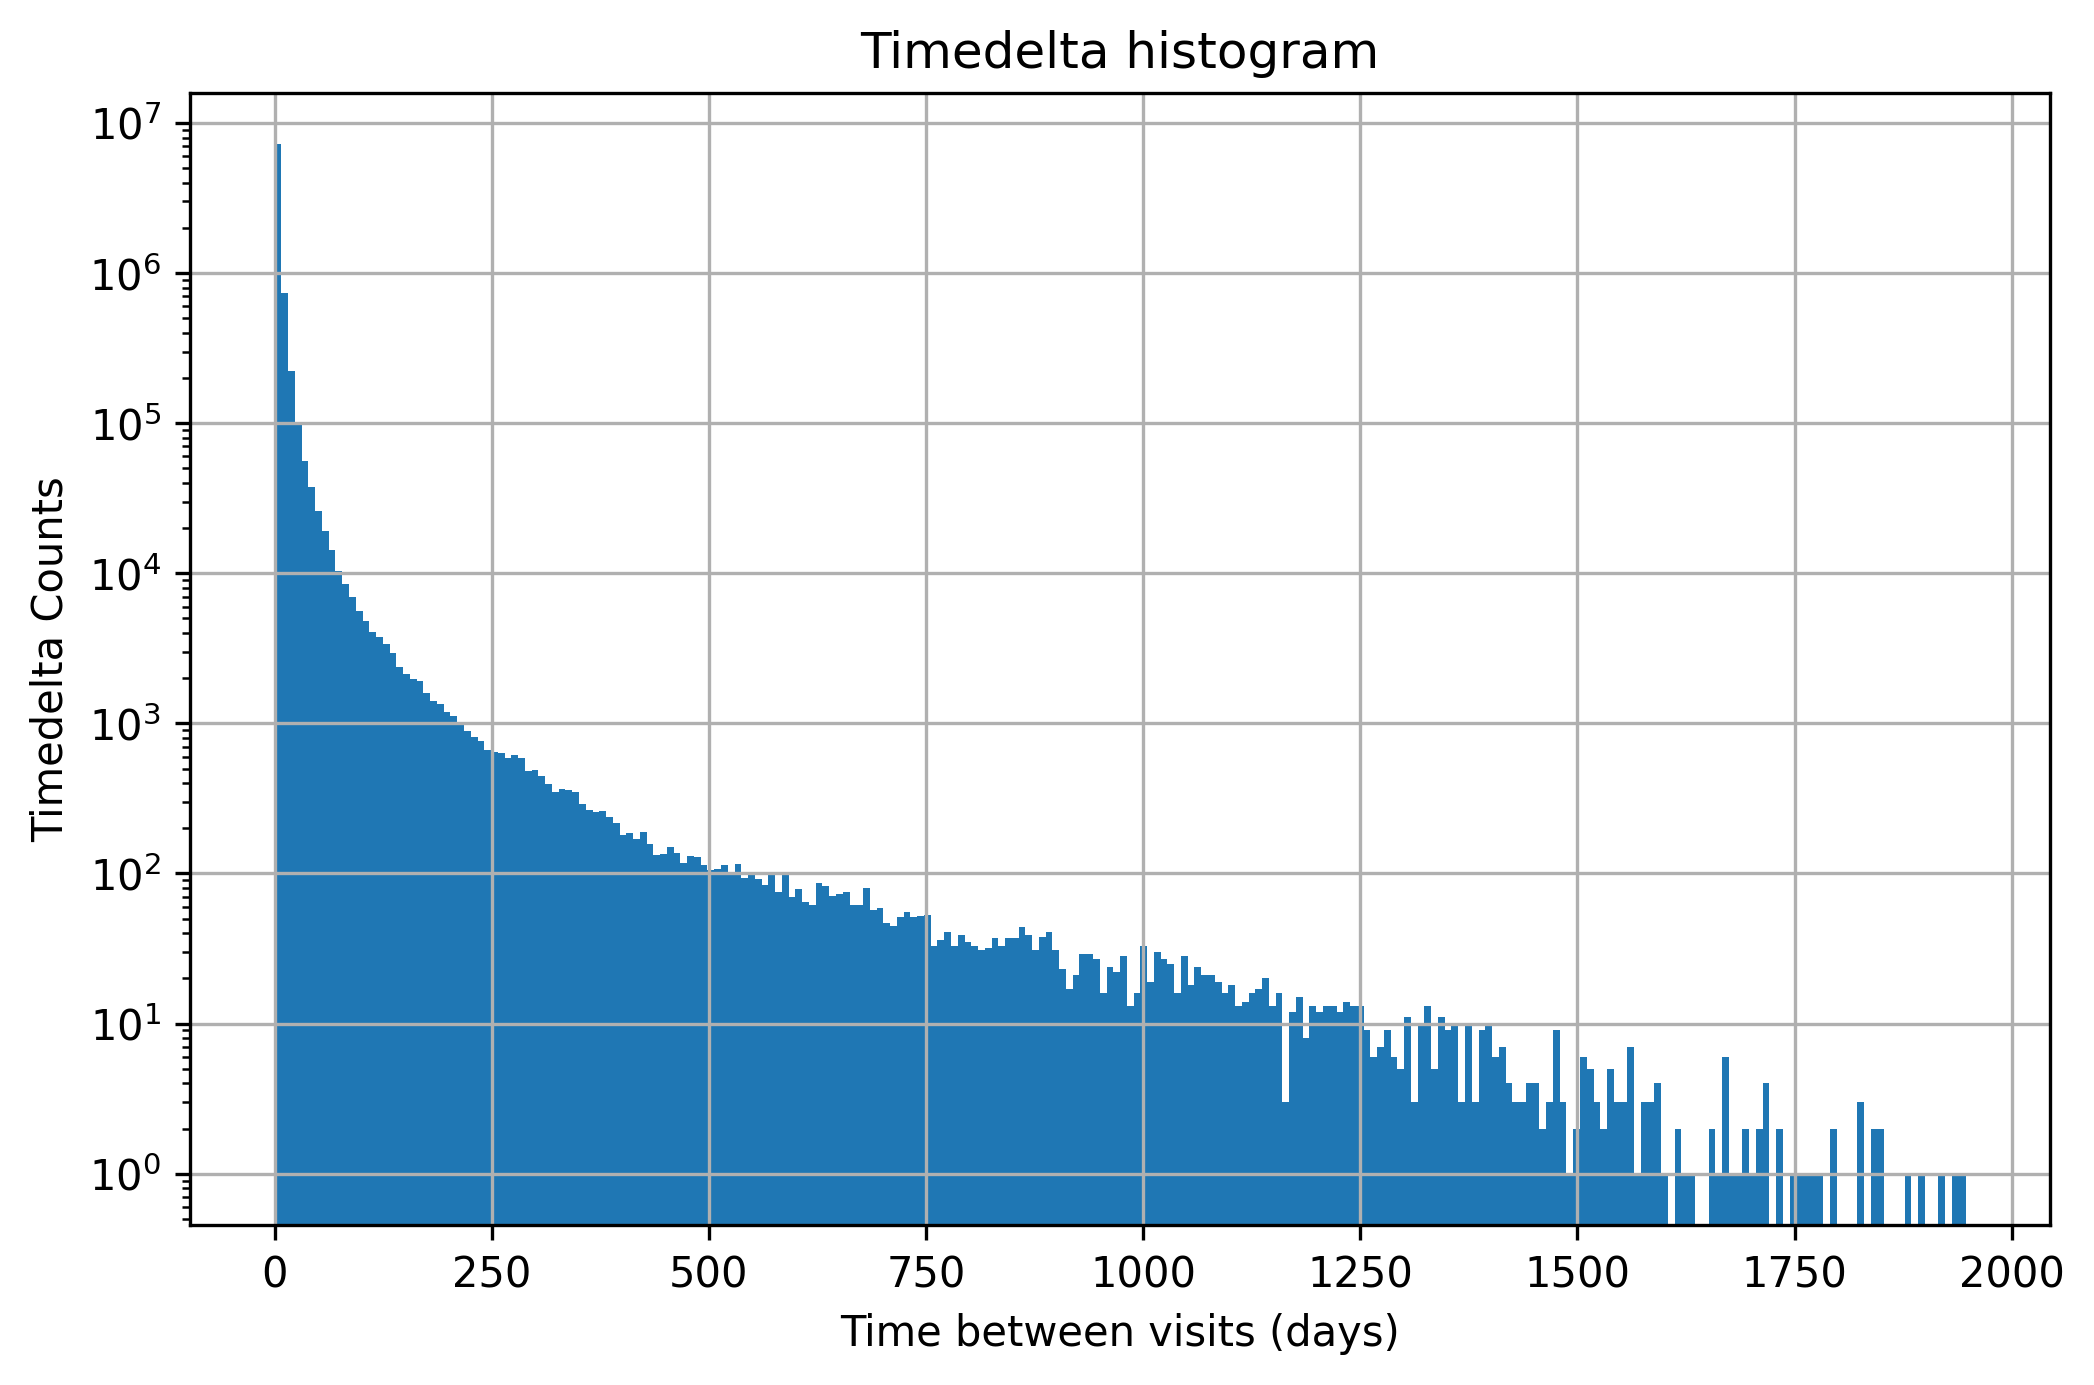

In [24]:
#thresh = 10 * (1 / (24 * 60))
fig2, ax2 = plt.subplots(figsize=(8,5), dpi=300)
#c = customer_features[customer_features.NUM_VISITS < 100]
td_sample.hist(bins=250, ax=ax2)
ax2.set_xlabel("Time between visits (days)")
ax2.set_ylabel("Timedelta Counts")
ax2.set_title("Timedelta histogram")
#ax.set_xlim(0,400)
ax2.set_yscale("log")


In [25]:
fig2.savefig("../plots/result_plots/td_hist.pdf", format='pdf', bbox_inches='tight')